# Cross-lingual Neural Vector Conceptualization

@author: Lisa Raithel, mailto: lisa.raithel@giance.ai

## Preparation

Import all necessary modules from the underlying code base.

In [1]:
from models.nvc_model import NeuralVectorConceptualizer
from models.embeddings import Embedding

import json
import numpy as np
import pandas as pd

Using TensorFlow backend.
/home/lraithel/miniconda2/envs/CLN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/lraithel/miniconda2/envs/CLN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/lraithel/miniconda2/envs/CLN/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/lraithel/minic

## Data

### Create the dataset from scratch (optional)

Create the "raw data" TSV file from the original Microsoft Concept Graph [database](https://concept.research.microsoft.com/Home/Download).
The script (thanks to leonhard.hennig@dfki.de) calculates all scores as described in [Wang et al. (2015)](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/scoring.pdf) and writes each instance and the associated scores to a tsv file.

*-infile*: path to the downloaded original data

*-outfile*: path to the file where you want to store the preprocessed data with REP scores

Unfortunately, due to some version updates, calculation of probabilities takes very long.
Until updated to Python3, we do not recommend to run this script.

The pre-calculated file is included in the data dump accompanying this notebook (`input_data/data-concept-instance-relations-with-rep.tsv`).

From this, we created the JSON file `input_data/raw_data_dict_fasttext_maxlenFalse.json`. It holds the same data, but filtered for instances that also belong to the fastText embedding vocabulary.

In [2]:
# %run -i utils/ms_concept_graph_scoring.py -infile data/data-concept-instance-relations.txt -outfile data/data-with-rep.tsv

### Load necessary modules and data

- Specify the input arguments
    - the name of the embedding model
    - the vocabulary limit
    - the path to the word vectors
    - the configuration file

- Load the embedding module and initialize the NVC model.

In [3]:
embedding_model_name = "fasttext"
voc_limit = None
embedding_data = "data/wiki.en.align.vec"
config_file = "results/fasttext_best_model/config_fasttext_aligned.json"

In [4]:
# loading fastText embeddings might take about ~ 10min
embedding = Embedding(
    embedding_or_raw_data_file=embedding_data,
    voc_limit=voc_limit,
    model_name=embedding_model_name,
    config_file=config_file)


10/04/2019 14:52:01 - INFO - gensim.models.utils_any2vec -   loading projection weights from /home/lraithel/datasets/fastText/wiki.en.align.vec


config file: results/fasttext_best_model/config_fasttext_aligned.json

Loading embedding data. This may take a while.

embedding file: /home/lraithel/datasets/fastText/wiki.en.align.vec
voc limit: None


10/04/2019 15:03:12 - INFO - gensim.models.utils_any2vec -   loaded (2519370, 300) matrix from /home/lraithel/datasets/fastText/wiki.en.align.vec



Embedding loaded.
Vocab size: 2519370, vector dims: 300


In [5]:
# load the conceptualizer
nvc = NeuralVectorConceptualizer(
    config_file=config_file, 
    embedding=embedding)

local devices: [name: "/cpu:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5734268539257639947
, name: "/gpu:0"
device_type: "GPU"
memory_limit: 10979036365
locality {
  bus_id: 1
}
incarnation: 5601853288771673959
physical_device_desc: "device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0d:00.0"
]
config file: results/fasttext_best_model/config_fasttext_aligned.json


In [6]:
# Show the configuration with which the model was trained
nvc.config

{'batch_size': 128,
 'classif_threshold': 0.5,
 'learning_rate': 0.001,
 'cross_val': 5,
 'check_concepts_for_cosine': False,
 'early_stopping': True,
 'embedding_combiner': False,
 'epochs': 500,
 'mcg_file_header': ['concept',
  'instance',
  'count',
  'p(c|e)',
  'p(e|c)',
  'rep',
  'empty'],
 'min_delta': 2e-05,
 'min_num_inst': 100,
 'min_rep': -10,
 'num_hidden_layers': 2,
 'max_length_of_instances': False,
 'patience': 4,
 'regularizers': [1e-08, 1e-08],
 'train_set_size': 0.8,
 'use_class_weights': False,
 'check_other_embedding': False,
 'min_count_of_instances': 0}

In [7]:
print("Embedding vocabulary size: {}".format(len(embedding.word_vectors.vocab)))

Embedding vocabulary size: 2519370


Load the already filtered data with the given parameters

In [8]:
# load the already filtered data
filtered_data = "data/filtered_data_i100_v-10_maxlenFalse.json"
nvc.load_data(path_to_data=filtered_data, filtered=True)

Loading existing filtered data file 'data/filtered_data_i100_v-10_maxlenFalse.json'.
Separating concepts and instances.
Creating data matrix.
shape filtered_data_matrix: (45513, 275)
#instances: 45513
#concepts: 275
Writing 2473857 instances to file 'results/words_not_in_mcg_i100_v-10_2019_10_04-15_03_fasttext.txt'.
Done.



To filter data for a new model, uncomment the cell below:

In [9]:
# # the raw data in JSON format
# path_to_raw_data = "input_data/raw_data_dict_fasttext_maxlenFalse.json""
# # OR the data in TSV format (when loading this file, a JSON is produced for further processing)
# # path_to_raw_data = "input_data/data-concept-instance-relations-with-rep.tsv"
# nvc.load_data(path_to_data=path_to_raw_data, filtered=False)

## Train a new NVC model

To train a new NVC model, uncomment the cell below. The details for training are set in the configuration file.

In [10]:
# nvc.train()

## Load a pre-trained NVC model

Load a pre-trained model by specifying the path to the h5 file and the test data.

In [11]:
model_path = "results/fasttext_best_model/model_minrep-10_mininst100_fasttext.h5"
test_set = "data/test_set.csv"
# load the pretrained model and report the results on the test set
# Note: we determined a threshold of 0.18 on the validation set
results_per_class_en, avrg_results_table_en = nvc.load_pretrained_model(trained_model=model_path, 
                                                                        x_val_file=test_set, 
                                                                        determined_threshold=0.18, 
                                                                        save_results=False)

Loading pretrained model: 'results/fasttext_best_model/model_minrep-10_mininst100_fasttext.h5'

Creating embedding and labels matrices ...
40000/45513 instances done
Done.
Avrg #positive concepts per instance: 1.1445740777360314
Avrg #instances per concept: 189.42909090909092

Results per concept (english vectors, threshold: 0.18):

          concept  precision    recall        F1  support
0    abbreviation   0.250000  0.076923  0.117647       26
1        academic   0.000000  0.000000  0.000000        7
2         acronym   0.666667  0.076923  0.137931       26
3             act   0.500000  0.090909  0.153846       22
4        activity   0.454545  0.625000  0.526316       16
..            ...        ...       ...       ...      ...
270          wine   0.100000  0.111111  0.105263        9
271         woman   0.235294  0.222222  0.228571       18
272          word   0.175439  0.270270  0.212766       37
273        worker   0.400000  0.133333  0.200000       15
274        writer   0.29411

In [12]:
# # write the results to a file
# results_per_class_en.to_csv("results/fasttext_best_model/results_per_class_english.csv",
#                             sep=";",
#                             header=["concept", "precision", "recall", "F1", "support"])

## Results

Run the model on the Chinese translations.

In [13]:
results_per_class_zh, avrg_results_zh = nvc.predict_and_evaluate_translations(datafile="data/instances_translated.jsonl")

#translated instances: 1288
#concepts:275


Done.
Avrg #positive concepts per instance (translations): 1.2608695652173914
Avrg #instances per concept (translations): 5.905454545454545

Results per concept (translated vectors, threshold: 0.18):
          concept  precision    recall        F1  support
0    abbreviation   0.000000  0.000000  0.000000        2
1        academic   0.000000  0.000000  0.000000        0
2         acronym   0.000000  0.000000  0.000000        0
3             act   0.000000  0.000000  0.000000        4
4        activity   0.092105  0.212121  0.128440       33
..            ...        ...       ...       ...      ...
270          wine   0.000000  0.000000  0.000000        3
271         woman   0.000000  0.000000  0.000000        0
272          word   0.135135  0.211268  0.164835       71
273        worker   0.000000  0.000000  0.000000        7
274        writer   0.000000  0.000000  0.000000        1

[275 rows x 5 columns]

Average results for translated vect

In [14]:
# # write the results to a file
# results_per_class_zh.to_csv("results/fasttext_best_model/results_per_class_chinese.csv",
#                             sep=";",
#                             header=["concept", "precision", "recall", "F1", "support"])

### Activation Profiles 
Show the activation profile of the word vector of *Confucius*. You can try all words/phrases that are in the embedding's vocabulary.

<Figure size 432x288 with 0 Axes>

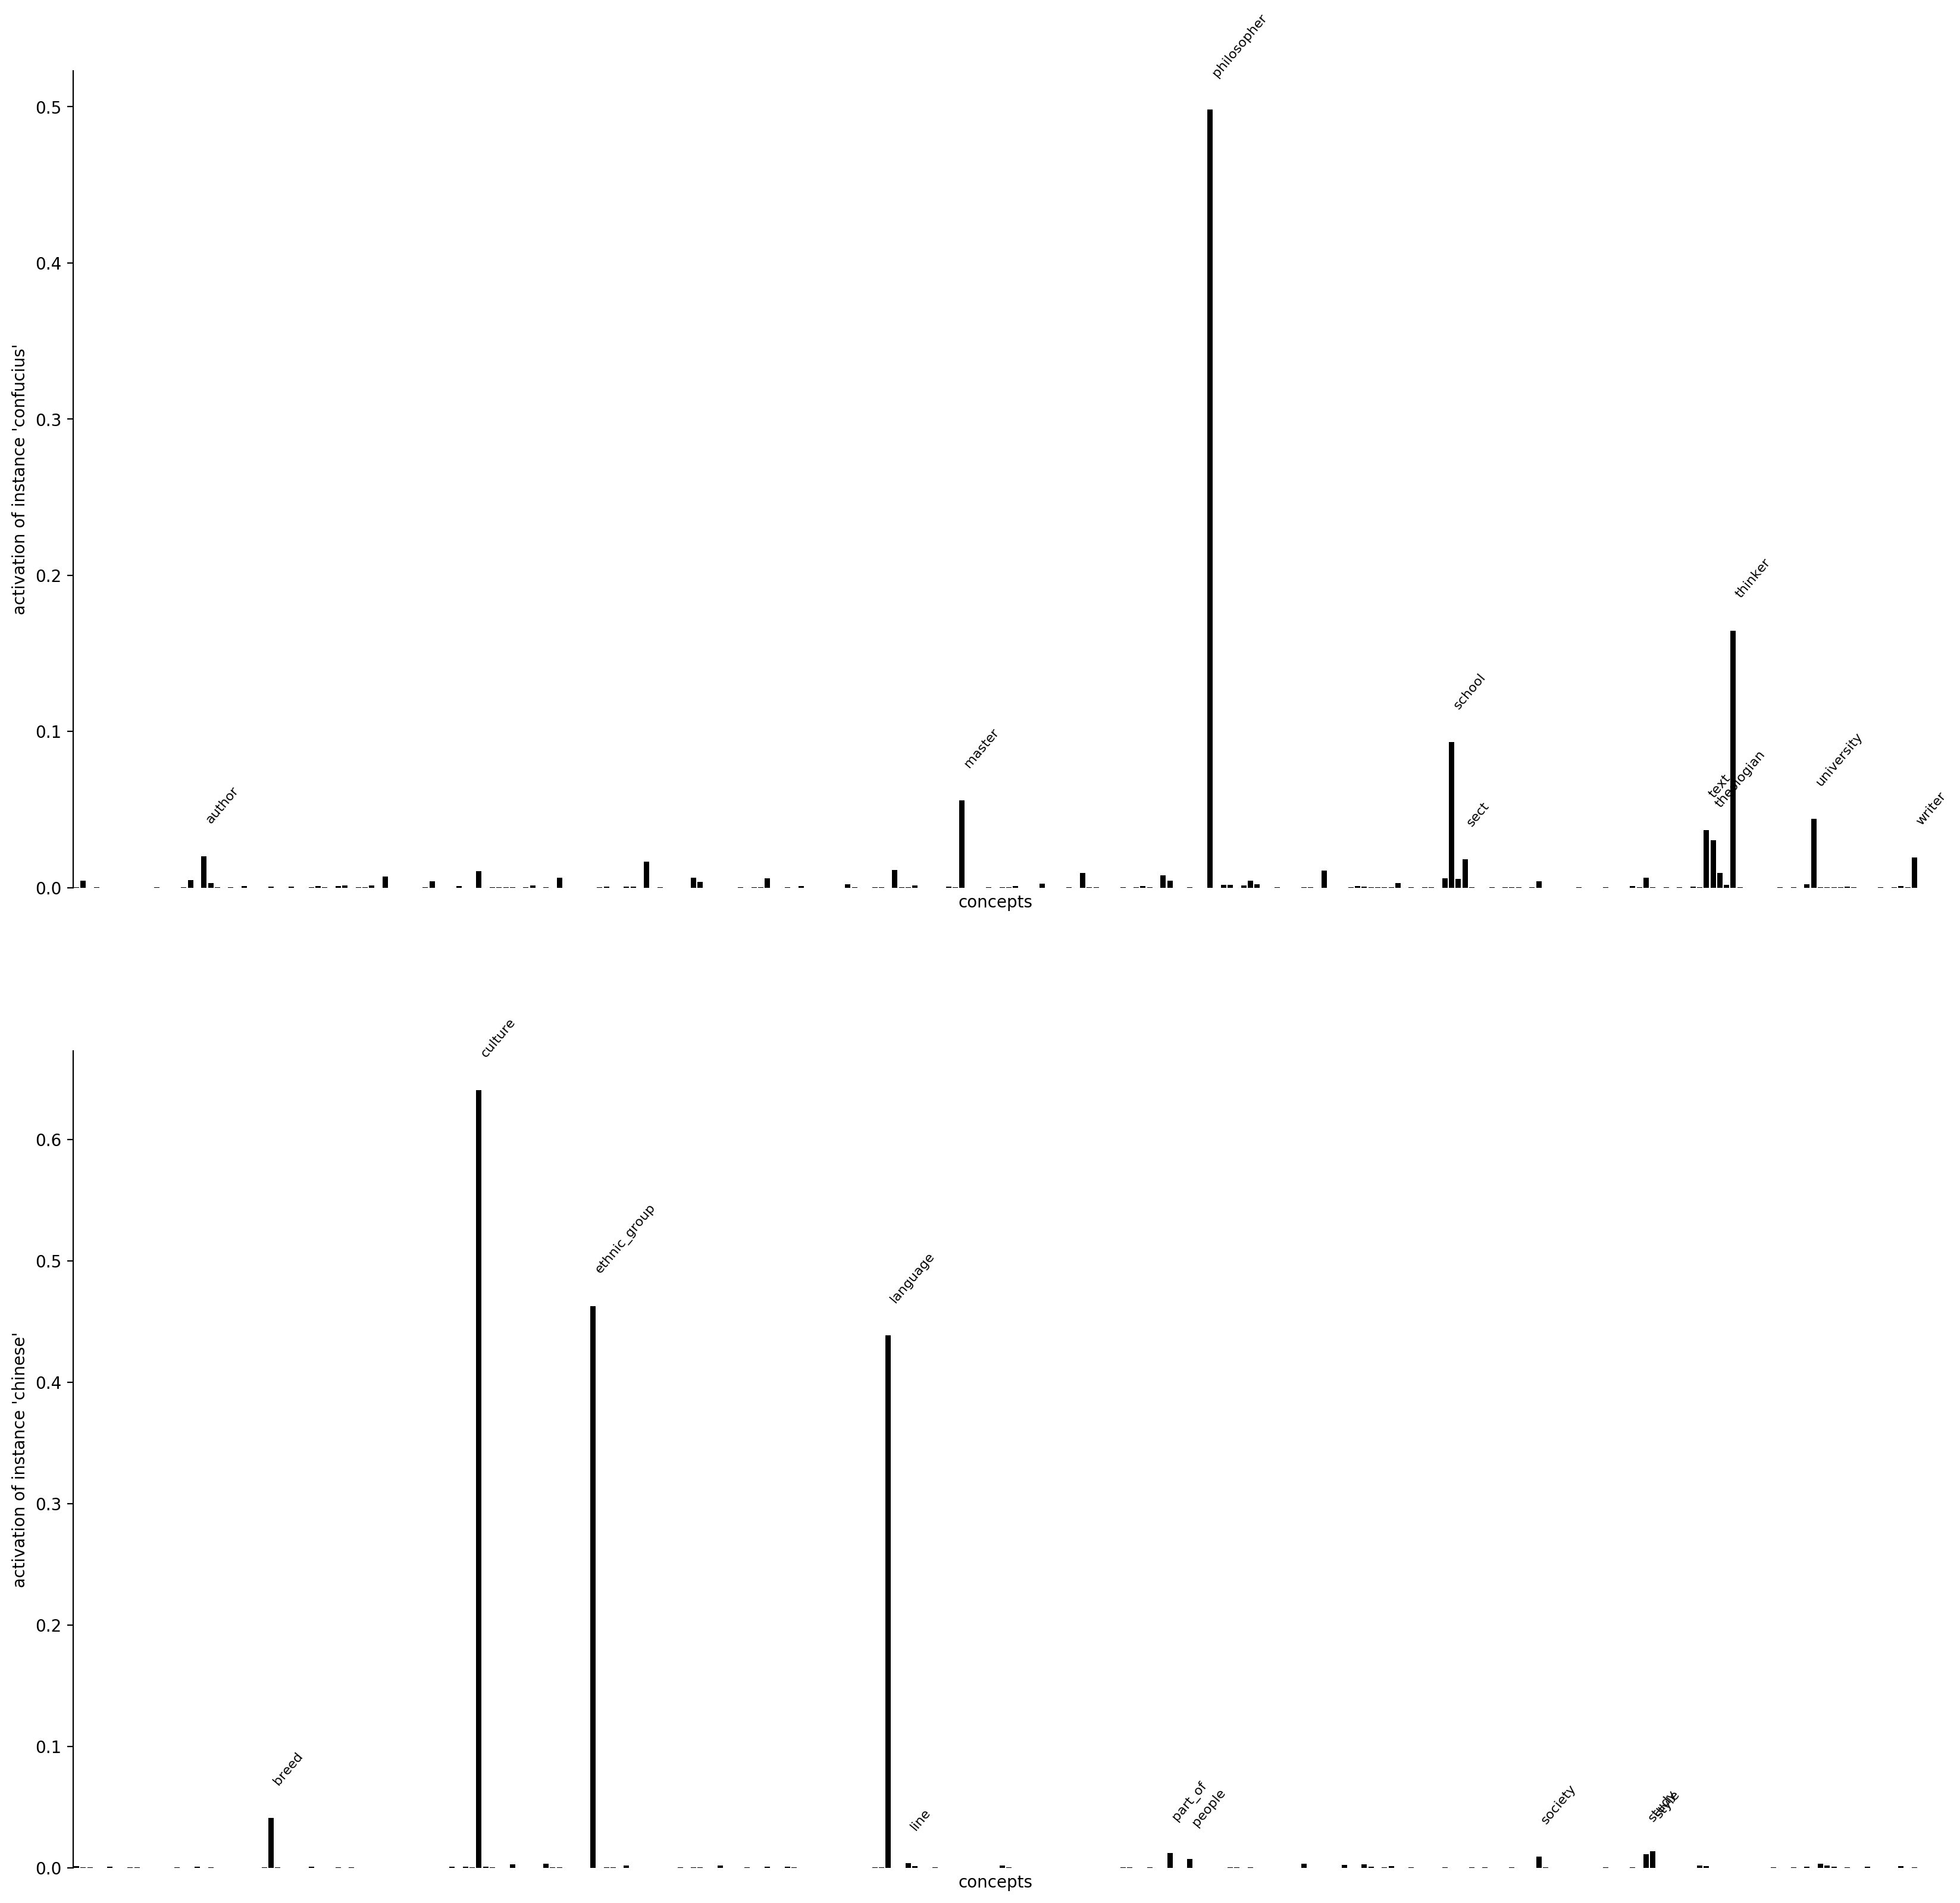

In [15]:
# show activations of English words
nvc.show_activations(instances=["confucius", "chinese"],
                     max_highlights=10, plot_cosine=False,
                     language="english")

shape input: (3, 300)


<Figure size 432x288 with 0 Axes>

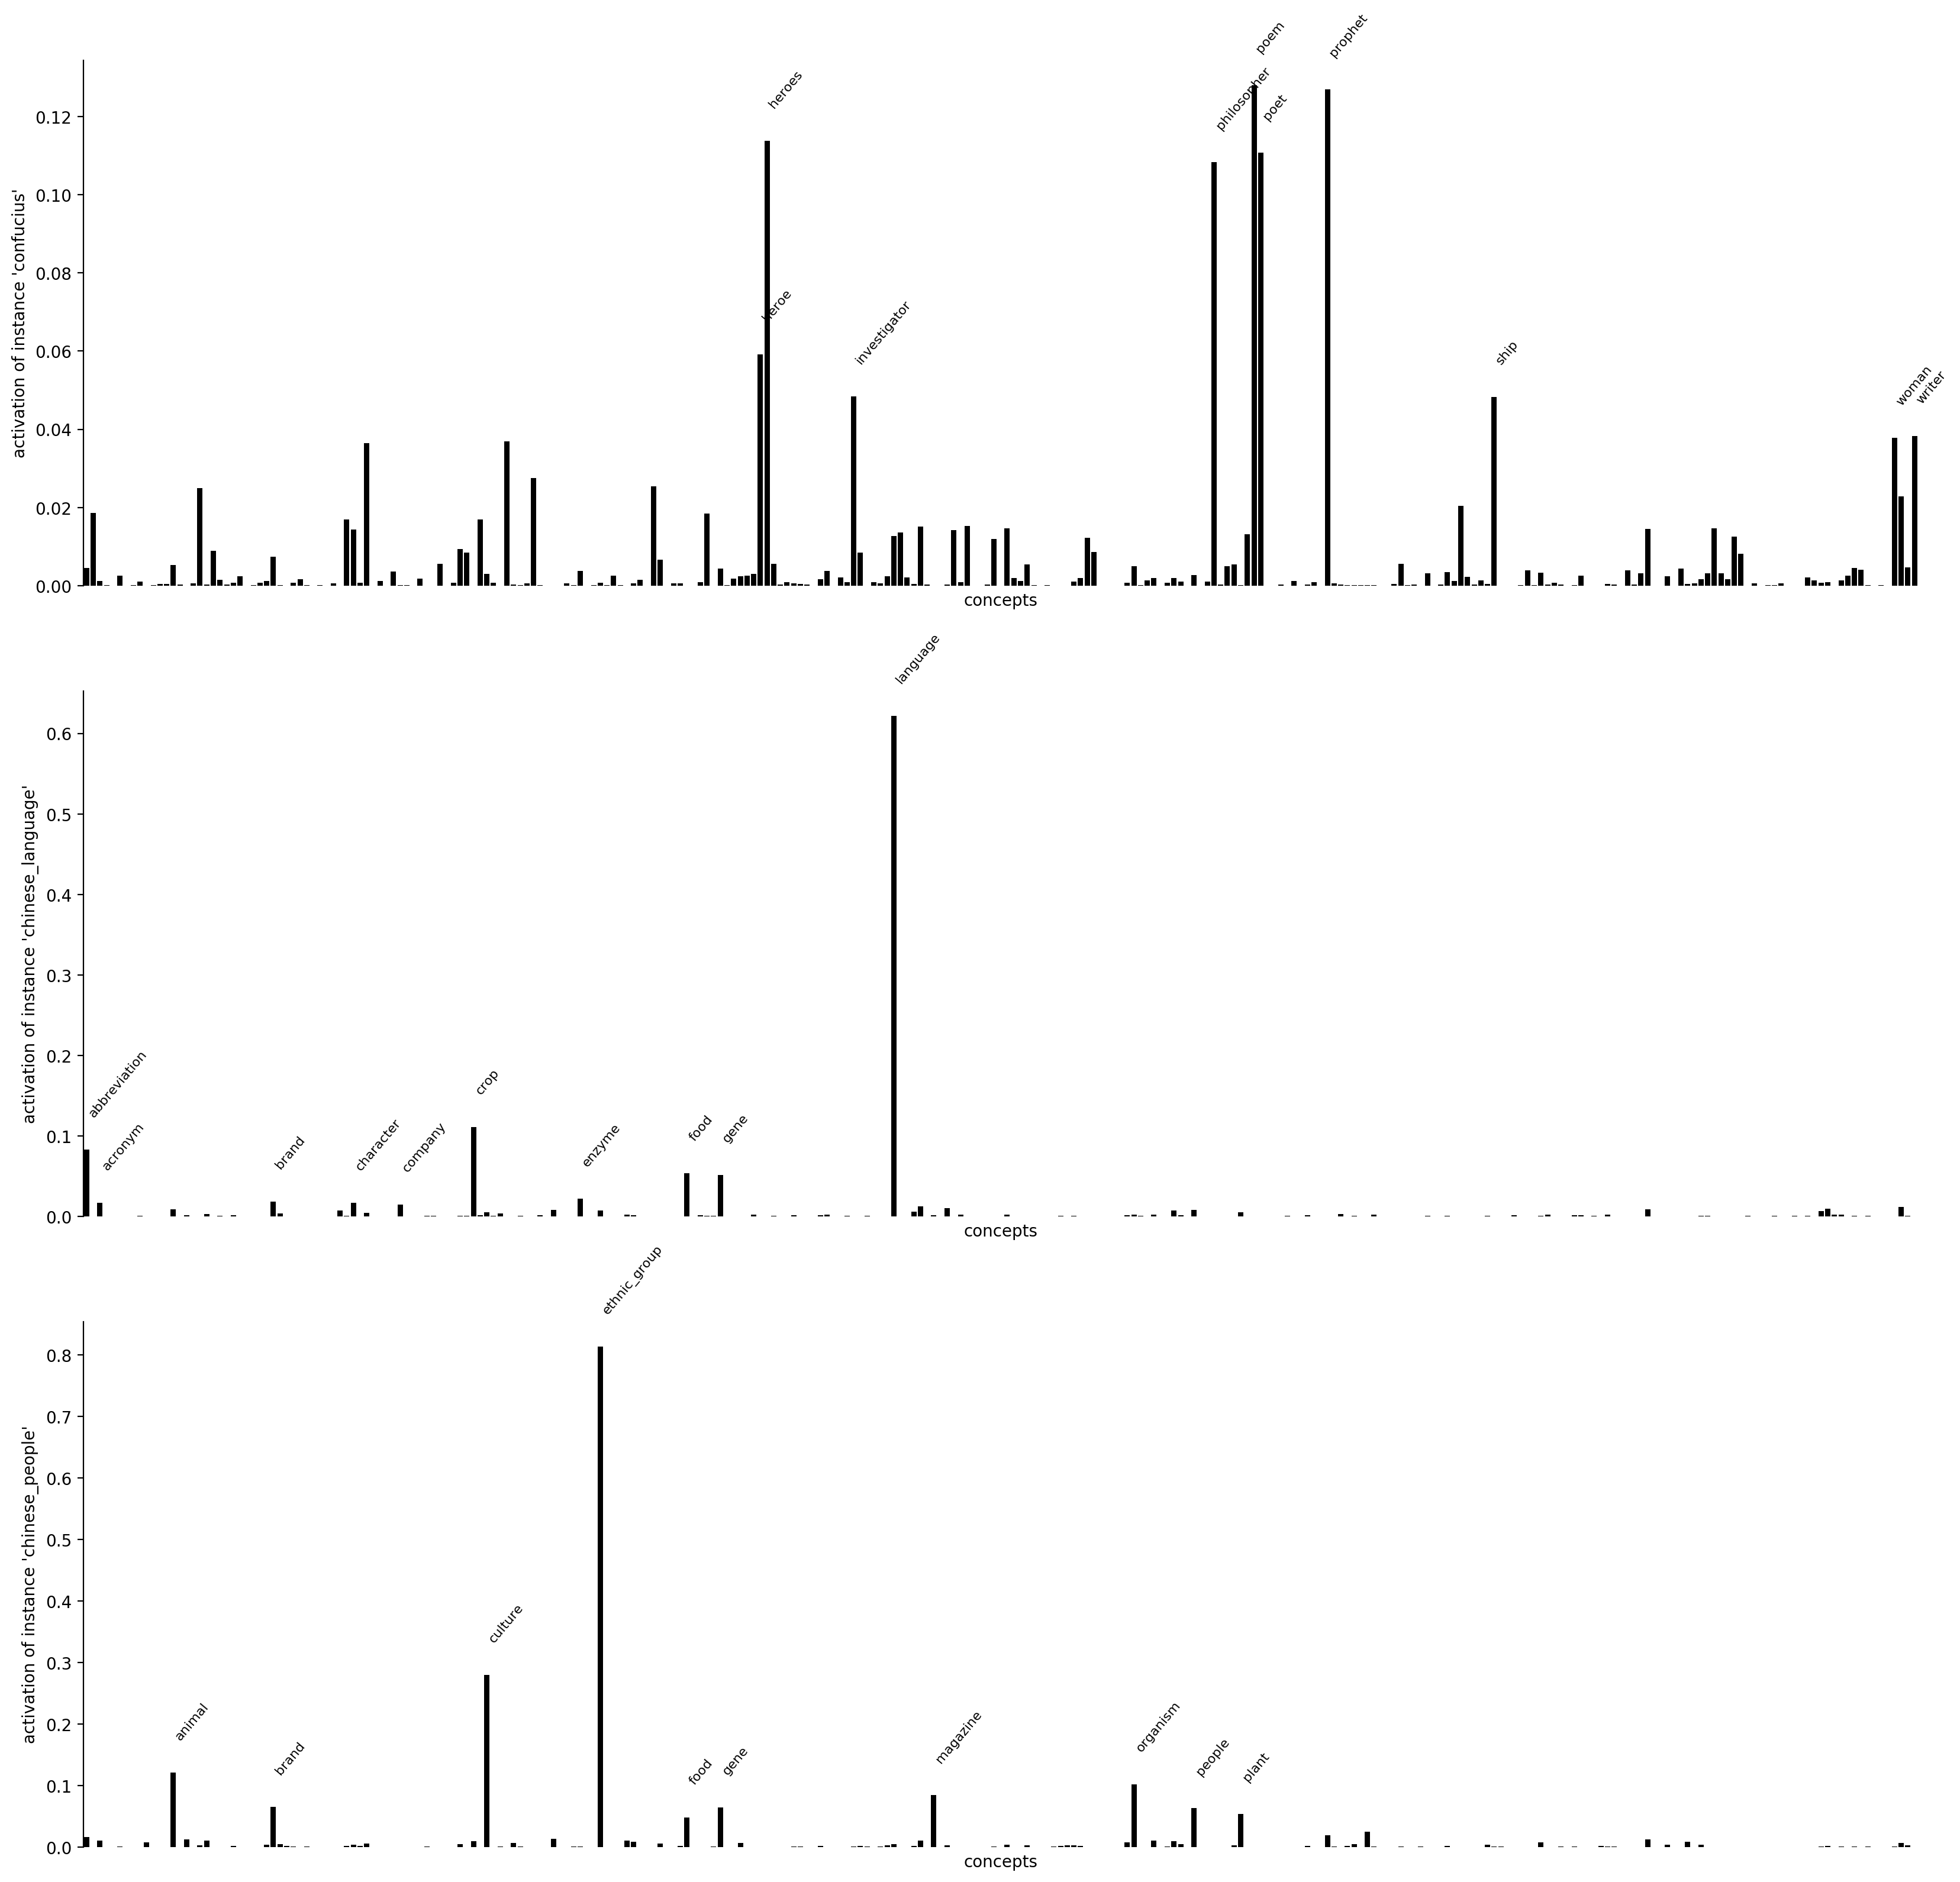

In [16]:
# get word vectors from Chinese embedding, e.g. "grep 孔夫子 wiki.zh.align.vec"

# 孔夫子
confucius_vector = "0.0343 0.0692 0.0978 0.0801 0.0938 0.1483 -0.1116 0.0121 0.0033 0.0478 -0.0396 -0.0703 0.0123 -0.0320 -0.0083 0.0227 -0.0573 0.1611 -0.0085 -0.1120 0.0213 0.0090 -0.0197 -0.0381 0.0713 0.0950 0.0353 -0.0230 -0.0552 -0.0256 -0.0175 -0.1144 -0.0251 0.0206 -0.0604 -0.0272 0.0464 -0.0374 -0.0216 -0.0152 -0.1172 -0.0206 -0.0211 0.0012 -0.0220 -0.0642 -0.0287 -0.0308 -0.0855 -0.0523 -0.0606 -0.0249 -0.0519 -0.0696 -0.0069 0.0566 0.0154 0.0407 0.1165 0.0187 0.1606 0.0568 0.0547 0.0621 0.0258 -0.0405 0.0623 -0.0062 0.0957 -0.0033 0.0313 -0.0308 -0.1213 -0.0533 0.0294 -0.0147 0.0007 0.0249 0.0407 0.0613 -0.0374 0.0069 0.0017 0.0888 -0.0199 0.0367 -0.0820 0.0263 -0.0706 0.0069 0.0748 -0.0109 0.0433 -0.1357 -0.0836 0.0798 -0.0410 -0.0978 0.0149 -0.0467 -0.0505 0.1196 -0.0036 -0.0308 -0.0561 0.1165 -0.0152 0.0514 0.0654 -0.0405 0.0019 0.0028 0.0213 -0.0907 -0.0765 -0.0306 0.0438 0.0467 0.0066 -0.0114 -0.0552 -0.1310 0.1289 -0.0436 -0.0050 0.0625 0.0083 -0.0692 -0.0370 -0.0185 0.0850 0.0654 -0.0083 0.0775 -0.0154 0.0140 0.0111 -0.0213 0.0237 -0.0613 0.0242 -0.0841 -0.0426 0.0223 0.0102 0.0618 -0.0024 -0.0751 -0.0500 0.0644 -0.0777 -0.0092 0.0573 0.0069 -0.0218 0.0464 -0.0325 0.0047 -0.1582 -0.0623 -0.0519 -0.0152 0.1106 -0.0073 -0.0500 0.0379 0.0670 0.0573 -0.0054 0.0185 -0.0322 0.0341 -0.0429 -0.0796 -0.0531 -0.0372 0.0438 0.0216 0.0756 0.0597 -0.0758 -0.0332 -0.0438 -0.0144 -0.0021 -0.0066 0.0021 -0.0296 0.0171 -0.0230 -0.0329 -0.1040 -0.0424 0.0429 -0.0547 -0.0585 -0.0438 0.0218 0.0192 -0.0488 -0.0753 -0.0005 -0.0009 -0.0261 -0.0251 0.0393 0.0126 -0.0265 -0.0012 0.0592 0.0133 -0.0156 0.0180 0.0384 0.0516 -0.0225 -0.0085 0.0561 -0.0770 -0.0028 0.0128 0.0028 -0.0320 -0.1665 -0.0523 -0.0410 -0.0777 0.1113 0.0988 0.0462 -0.0317 0.0744 0.0310 -0.0396 0.0618 0.0315 -0.1021 -0.0703 -0.0367 -0.0910 -0.0990 -0.0128 0.0291 0.0050 -0.0535 -0.0770 0.0483 0.0291 0.0613 -0.0978 0.0102 0.0400 -0.0656 0.1151 -0.0062 0.0123 -0.0126 0.0796 0.0346 -0.0173 -0.0822 -0.0298 0.0225 0.0045 0.0047 0.0012 0.0334 0.0488 0.0128 0.0564 0.0900 0.0185 -0.0985 -0.0033 0.0573 -0.0173 -0.0701 -0.1307 -0.0711 -0.0478 -0.0045 0.0005 0.0332 -0.0509 -0.0144 -0.0469 -0.0062 0.0325 0.0535 0.0602 -0.0995 -0.0069 0.0261 -0.0277 -0.0784 0.0232 0.0379 -0.0568 -0.1471 0.0910"

# 汉语
chinese_language = "-0.0357 0.0474 0.0937 -0.0204 0.0234 -0.0209 -0.1337 0.0639 0.0558 -0.0756 0.0377 -0.0229 -0.0053 -0.0448 0.0084 0.0130 0.0619 -0.0160 0.0097 -0.0479 -0.0295 -0.0481 0.0611 -0.0364 0.0507 0.1164 0.1294 -0.0069 -0.0025 0.0125 -0.0507 -0.0219 -0.0107 0.0262 -0.0003 -0.0471 0.0138 -0.0079 0.1217 0.0341 -0.0171 0.0359 0.0616 0.0201 -0.0227 -0.0171 -0.0117 -0.0494 -0.0507 -0.0802 0.0349 -0.0410 0.0571 -0.0782 -0.0751 0.0209 0.0436 -0.0023 0.0537 0.1029 0.1128 -0.0665 -0.0211 0.0553 -0.0188 0.0061 -0.0374 -0.0239 -0.0550 0.1060 0.0084 0.0232 -0.0601 -0.0728 0.0092 0.0199 -0.0048 0.0127 0.0652 0.0609 0.0323 -0.0214 -0.0820 0.0759 0.0708 0.0387 -0.0996 0.0171 -0.0357 0.1251 0.0148 -0.0176 0.0199 -0.0812 0.0257 -0.0298 -0.0420 -0.0275 0.0227 -0.0484 0.0010 -0.0593 0.0331 0.0084 -0.0288 0.0461 0.0155 -0.0216 0.0525 0.0082 0.0874 -0.0863 0.0395 -0.1358 -0.0186 0.0018 0.0053 0.0341 0.1006 -0.0000 -0.0410 0.0331 0.0204 -0.0413 0.1261 0.0013 -0.0048 -0.0420 -0.0270 0.0978 0.1378 -0.0385 0.0759 0.0512 0.0160 0.0186 -0.0135 -0.0204 0.0927 0.0599 -0.0186 -0.0178 0.0127 0.1141 0.0583 -0.0413 -0.0443 -0.0145 -0.1024 -0.0436 0.0400 0.0436 0.0150 -0.0362 0.0349 -0.0257 0.0601 0.0858 -0.0975 -0.0273 0.0553 0.0402 -0.0357 0.0023 0.0986 -0.0087 0.0346 0.0043 0.0619 -0.0181 -0.0160 0.0104 -0.0428 -0.0025 -0.0313 0.0150 0.0206 0.0578 0.0379 -0.0311 -0.0150 -0.0018 0.0025 0.0919 0.0061 0.0560 0.0028 0.1044 -0.0005 0.0339 -0.0425 -0.0306 0.0542 0.0336 -0.0031 -0.0155 0.0064 -0.0565 -0.0571 0.0069 -0.0038 -0.0759 -0.0293 -0.0537 0.0232 -0.0522 -0.1113 -0.0194 0.0321 -0.0280 -0.0596 0.0868 -0.0415 0.0525 -0.0061 -0.0428 -0.0397 0.1174 -0.1098 0.0051 0.0953 -0.0239 -0.1271 0.0013 -0.0975 -0.0927 -0.0970 0.0769 0.0183 0.1289 -0.0148 0.0089 0.0548 -0.0922 -0.0084 0.0486 -0.0413 -0.0293 -0.0013 0.0323 -0.1205 -0.0000 0.0993 -0.0092 0.0606 0.0754 -0.0571 0.1032 -0.0115 0.0301 -0.0199 0.0316 -0.0698 0.0270 -0.0807 -0.0367 0.0379 0.0237 0.0856 -0.0413 0.0708 -0.0548 0.0940 -0.0341 0.0234 0.0066 -0.0593 -0.1075 0.0066 0.0379 -0.0840 0.0988 -0.0150 -0.1414 0.0871 0.0374 0.0433 -0.0996 0.0273 -0.0876 0.1136 0.0092 0.0051 -0.0405 -0.0229 -0.1363 -0.0392 -0.0451 -0.0446 -0.0051 -0.1121 -0.0502 0.0779 -0.0535 -0.0876 -0.0120 0.1093 -0.0818 -0.1215 0.0453"

# 华人 
chinese_people = "0.0092 0.0736 0.0879 0.0306 0.0574 0.0284 -0.0409 0.0005 0.0587 -0.0181 0.0492 -0.0336 0.0433 0.0387 -0.0070 0.0419 0.0384 -0.0663 0.0038 -0.0284 -0.0798 0.0492 -0.0308 -0.0739 0.1521 0.1807 0.0219 -0.0533 0.0795 0.0003 -0.0530 -0.0693 -0.0441 -0.0295 -0.0877 -0.0114 0.0649 -0.0476 0.1074 0.1220 -0.1453 -0.0060 -0.0690 0.0246 -0.0051 0.0425 -0.0365 -0.0290 -0.0779 -0.1778 0.0455 0.0214 0.1036 -0.0595 -0.0322 0.0425 -0.0152 0.0620 0.0233 -0.0492 0.0325 -0.0008 0.0468 0.0519 -0.0216 0.0874 -0.0108 -0.0701 -0.0406 0.0390 -0.0406 -0.0127 -0.0005 -0.1864 -0.0400 0.0262 0.0517 -0.0365 0.0411 0.0720 0.0436 -0.0330 -0.0417 0.0333 0.0866 -0.0703 -0.0898 -0.0168 -0.0062 0.0260 -0.0035 0.0749 -0.0124 -0.0850 0.0417 -0.0038 -0.0216 -0.0005 -0.0403 0.0338 0.0073 0.0749 0.0203 -0.0647 -0.0436 0.1499 0.0100 0.0982 0.0433 -0.0238 0.0836 0.0014 0.0509 -0.0633 0.0955 0.0390 -0.0114 0.0476 0.0460 -0.0795 -0.0022 0.0211 0.1209 -0.0628 0.0693 -0.0344 0.0663 0.0130 -0.0244 0.0087 0.0130 0.0514 0.0703 0.0070 -0.0179 0.0049 -0.0276 -0.0249 0.0820 0.0576 0.0279 0.0812 0.0187 0.0833 -0.0060 -0.0022 -0.0298 0.0663 -0.0398 0.0154 -0.0804 -0.0695 -0.0303 -0.0568 -0.0095 -0.1020 -0.0246 -0.0170 0.0016 -0.0200 0.0087 0.0043 0.0468 0.0260 0.0858 -0.0073 0.0490 0.0758 0.1174 -0.0357 0.1131 0.0225 -0.0490 0.0022 -0.0468 -0.0060 0.0660 -0.0087 0.0233 0.0509 0.0795 -0.0457 0.0192 0.0906 0.0214 0.0314 0.0303 0.0530 0.0027 -0.1058 0.0162 -0.0666 0.0295 0.0603 -0.0836 -0.0371 -0.0024 0.0373 -0.0465 0.0544 0.0801 -0.0633 -0.0371 -0.0111 -0.0114 -0.0284 -0.0925 -0.0060 0.0406 0.0630 -0.0152 -0.0630 0.0127 -0.0100 -0.0752 -0.1269 0.0276 0.0771 -0.0752 -0.0417 -0.0298 0.0319 -0.0679 -0.0254 -0.0390 -0.0143 -0.0628 0.0227 0.0998 0.1245 0.0731 0.0403 0.0271 -0.0200 -0.0073 -0.0584 -0.0547 0.0271 -0.0322 -0.0260 -0.0211 0.0855 0.0471 0.0519 0.1131 0.0476 -0.0825 0.0814 0.0514 -0.0122 -0.0703 -0.0693 0.0241 0.0246 -0.0400 0.0192 0.0087 0.0078 -0.0035 0.0674 -0.0143 -0.0468 0.0671 -0.0298 -0.0376 -0.0143 -0.0073 -0.0801 0.0116 0.0084 0.0514 0.0268 -0.0030 -0.0820 0.0068 0.0533 0.0176 -0.0939 0.0760 -0.1253 0.1017 -0.0833 -0.0346 -0.0005 0.0739 -0.0676 -0.0528 -0.0262 -0.0244 0.0246 -0.0333 -0.0198 0.0595 -0.0303 -0.1253 0.0154 -0.0368 -0.0011 -0.1190 0.0682"

# # 狗 (dog, doggy, pooch, doggie, hound, mutt)
# dog_1_vector = "0.0301 0.0605 0.1108 -0.0562 0.0250 0.0101 -0.0581 -0.0141 0.0437 0.0280 0.0171 -0.0197 0.1055 0.0195 0.0352 0.0133 0.0035 -0.0967 0.0091 0.0011 -0.0773 0.0386 0.0005 -0.0786 0.0200 0.1207 0.0674 -0.0306 -0.0384 0.0226 -0.0663 -0.0069 -0.0096 0.0354 -0.0211 -0.0330 -0.0160 0.0429 0.0727 -0.0096 -0.0456 0.0301 0.0432 0.0866 0.0378 0.0666 -0.0493 -0.0005 -0.0671 -0.1013 0.0690 -0.0117 0.0669 -0.1172 -0.0722 0.0163 -0.0200 0.0629 0.0261 0.0099 0.0981 0.0250 0.0933 -0.0298 -0.0061 -0.0144 0.0562 -0.0096 -0.0229 0.0613 0.0088 -0.0181 -0.0258 -0.1172 0.0027 0.0453 0.0805 0.0962 -0.0008 -0.0013 0.0091 0.0069 -0.1039 0.0136 0.0096 0.0160 -0.0378 0.0397 -0.0991 0.0746 0.0690 0.0885 0.0778 -0.0144 0.0242 0.0394 -0.0152 -0.0245 0.0386 0.0024 0.0077 -0.0877 0.0522 0.0013 -0.0799 -0.0248 -0.0645 0.0837 0.0560 -0.0051 0.0557 0.0053 0.0317 -0.0285 0.0032 -0.0432 0.0035 0.1005 0.1023 0.0903 0.0560 0.0274 0.0320 0.0261 0.0922 -0.0280 0.1122 -0.0269 0.0008 0.0490 0.0488 0.0242 0.0341 0.0141 -0.0226 0.0693 -0.0147 0.0093 0.1084 0.1186 0.0077 0.0557 0.0687 0.0845 -0.0682 0.0029 -0.0179 0.0003 -0.0394 -0.0141 -0.0107 -0.0152 0.0682 0.0237 0.0570 -0.0378 0.0125 0.0709 -0.0762 0.0450 -0.0059 0.0970 -0.0352 -0.0517 0.0957 0.0738 0.0530 0.0592 0.0426 -0.0245 0.0136 0.0240 -0.0533 -0.0011 -0.0051 -0.0496 0.1114 0.0658 -0.0152 0.0490 -0.0136 0.0400 -0.0597 0.0568 0.0509 0.0461 0.0139 0.0850 0.0368 0.0096 0.0043 -0.0957 0.0893 -0.0317 -0.0037 -0.0040 -0.0434 0.0115 -0.1252 -0.0149 0.0338 -0.0378 -0.0576 -0.0266 0.0067 0.0061 -0.1196 -0.0192 0.0397 -0.0016 0.0067 0.0184 -0.0152 -0.0389 -0.0698 -0.0690 -0.0171 0.1391 -0.0432 0.0181 0.0192 0.0141 -0.1212 -0.0496 -0.0711 -0.0208 -0.0576 0.0128 -0.0096 0.0759 0.0104 0.0941 0.1068 -0.0448 0.0426 -0.0474 -0.1132 -0.0077 -0.0056 -0.0229 -0.0448 0.0200 0.1164 -0.0450 0.1314 0.0781 0.0312 0.0965 0.0322 0.0983 0.0240 -0.0234 -0.0789 0.0797 -0.0200 0.0266 -0.0003 -0.0147 0.1076 0.0354 0.1207 -0.1015 0.1175 -0.0493 0.0099 0.0554 -0.1172 -0.0024 0.0197 -0.0791 -0.0069 0.0751 -0.0197 0.0139 0.0512 -0.0333 0.0685 -0.0253 0.0413 -0.0448 0.0749 -0.0125 -0.0418 -0.0373 0.0706 -0.1735 -0.0906 0.0749 -0.1106 0.0197 0.0083 0.0216 0.0538 -0.0791 -0.0533 -0.0464 -0.0440 -0.1236 -0.1106 -0.0035"
# # 犬 (dog)
# dog_2_vector = "-0.0134 -0.0196 0.0218 0.0477 0.0428 0.0213 -0.0521 -0.0033 0.0166 0.0027 0.0155 -0.0254 0.0818 -0.0720 0.0504 -0.0360 -0.0294 -0.0474 -0.0199 0.0055 -0.0461 0.0368 -0.1361 -0.1140 -0.0360 0.0425 -0.0234 -0.0916 0.0060 0.0706 0.0139 0.0796 -0.0106 0.0308 0.0802 -0.0548 0.0374 0.0234 -0.0218 0.0480 0.0453 -0.0864 0.0259 0.0616 0.0354 0.0333 -0.0379 -0.0630 -0.0044 -0.0390 0.0693 0.0191 0.0027 -0.0521 -0.0150 0.0897 -0.0264 -0.0101 0.0005 0.0041 0.0314 -0.1145 0.0657 0.0087 0.0324 -0.0210 -0.0826 -0.0082 0.0005 0.0147 0.0488 -0.0900 -0.0065 -0.1666 -0.0526 -0.0363 0.0864 0.1366 0.0145 0.0104 0.0690 -0.0851 -0.0821 -0.0545 -0.0204 0.0780 -0.0761 0.0663 0.0971 0.0267 -0.0534 0.0360 -0.0423 -0.0180 0.0510 0.0289 0.0477 -0.0769 -0.0753 0.0750 0.0005 -0.0319 0.0134 -0.0128 -0.0706 0.0104 -0.0188 0.0540 0.0766 -0.0275 0.0322 0.0286 -0.0802 -0.0783 0.0409 -0.0684 0.0499 -0.0199 0.0562 0.0436 0.1480 -0.0068 0.1224 0.0540 0.0510 -0.0360 0.0886 0.0376 0.0174 0.0725 -0.0003 0.1314 -0.0262 0.0611 -0.0374 0.0652 -0.0256 -0.0821 0.0087 0.1216 0.0145 0.0949 0.0586 0.1238 -0.0679 0.1012 0.0543 -0.0521 0.0477 0.0823 0.0142 -0.0821 -0.0327 -0.0232 -0.0011 -0.0199 0.0112 0.0379 0.0174 -0.0485 0.0139 0.0466 -0.0439 -0.0469 0.1044 -0.0690 0.0360 0.0286 0.0924 0.0507 -0.1058 -0.0142 -0.0709 -0.0164 0.0941 0.0338 -0.0016 0.0109 0.0338 0.0354 -0.0875 -0.0815 0.0608 0.0834 -0.0273 -0.0125 -0.0335 0.0485 0.0747 0.1167 -0.0581 -0.1674 0.0218 0.0060 -0.0660 -0.0330 -0.0207 0.0142 -0.0643 0.0155 0.0379 -0.0365 -0.1080 0.0455 -0.0488 -0.0368 -0.1251 -0.0671 0.0142 -0.0431 0.1104 0.0025 0.0003 0.0060 -0.0120 -0.0502 0.0049 0.0434 -0.0196 -0.0256 0.0191 -0.0744 -0.1161 0.0273 -0.0464 -0.0573 -0.0992 -0.0248 -0.0387 0.0930 0.1164 0.0744 -0.0363 -0.0504 -0.0493 0.0183 -0.1039 0.0352 -0.0679 -0.0455 -0.0191 0.0753 0.0671 0.0319 0.0431 -0.0158 0.0262 -0.0164 0.0150 0.0881 -0.0153 -0.0297 -0.0104 0.0324 -0.0030 -0.0221 -0.0194 -0.1279 0.0251 -0.0033 0.0712 0.0365 0.0401 -0.0316 -0.1115 0.0398 0.0292 -0.0019 0.0153 0.0014 -0.0431 0.0840 0.0046 -0.0232 -0.0041 -0.0450 0.0273 -0.0169 0.0046 0.0224 0.1156 -0.0507 -0.0256 -0.0131 0.0379 -0.0491 0.0112 0.0532 -0.1006 -0.0575 0.0218 -0.0930 0.1211 0.0248 -0.0589 -0.0774 -0.0434 0.0150 -0.0207 0.0074"

# # 蔷薇 (rose)
# rose_1_vector = "0.0105 0.0150 0.0705 -0.0417 0.0489 -0.0337 0.0256 0.0112 0.0074 -0.0660 0.0581 -0.0660 0.0586 -0.1037 -0.0355 0.0007 -0.0469 -0.1306 -0.0880 0.0487 0.0256 -0.0862 -0.0505 -0.1064 0.0337 0.0191 0.0272 -0.0301 0.1010 -0.0180 0.0263 -0.0386 0.0386 -0.0310 0.0099 -0.0577 -0.0772 -0.0391 0.0882 -0.0507 0.0489 -0.0343 -0.0121 0.0121 0.0184 0.0658 -0.0168 0.0052 0.0227 -0.0072 -0.0155 -0.0132 -0.0595 -0.0110 0.0644 0.0698 -0.0417 -0.1414 0.0914 0.0530 -0.0274 -0.0034 0.0714 -0.0036 0.0177 0.0947 -0.0761 -0.0359 -0.0507 0.0873 0.0229 0.0189 0.0231 -0.0615 -0.0319 0.0323 -0.0956 -0.0689 0.0763 0.0105 -0.0586 -0.0532 -0.0049 0.0022 -0.0162 0.0312 0.0305 -0.0714 0.0534 0.0570 -0.0395 -0.0141 -0.1818 0.1071 -0.0911 -0.0290 -0.0525 0.1120 0.0588 -0.0094 -0.0040 0.0368 0.0404 -0.0631 0.0988 0.0361 -0.0510 0.0770 0.0438 -0.0671 0.1001 -0.0438 0.0552 -0.0063 -0.0994 0.0272 0.0097 -0.0469 0.1367 0.0736 0.0153 0.0433 0.0770 0.0337 0.0671 0.0352 -0.0516 -0.0456 -0.1304 -0.0038 0.0411 0.0274 -0.0377 0.0016 0.0290 0.0022 -0.0662 0.0530 0.0494 -0.0914 0.0611 -0.0285 0.0543 0.0516 0.0649 -0.0061 -0.1165 0.0759 0.0305 0.1248 -0.1064 -0.1066 0.0736 0.0698 -0.1102 -0.0110 0.0914 0.0274 0.0449 0.0330 0.0557 -0.0097 0.0339 -0.0200 -0.0624 0.0501 0.0195 0.0294 -0.0624 -0.0139 -0.0462 -0.0492 -0.0061 -0.0249 0.0402 -0.0052 0.0040 -0.0247 0.0171 -0.0669 -0.0018 0.0123 -0.0258 -0.0168 -0.1039 -0.0763 -0.0139 0.1035 0.0505 0.0126 0.0290 -0.0510 0.0049 0.0469 -0.0247 0.0177 0.0083 -0.0536 -0.0195 0.0180 0.0211 -0.0193 0.0186 -0.0150 0.0543 -0.0045 -0.0527 -0.0233 -0.0034 0.0249 -0.0813 -0.0281 -0.1109 -0.0148 0.0240 -0.0828 0.0734 0.0880 0.0914 -0.0137 0.0720 0.0357 -0.0238 0.0779 -0.0696 -0.0637 -0.0698 0.1080 0.0067 -0.0563 -0.0763 0.0837 -0.0213 -0.0568 0.0198 -0.0382 0.0079 0.0534 -0.0426 0.0117 -0.0923 -0.0373 0.0433 -0.0112 -0.0184 0.0595 -0.0456 -0.0020 0.1158 0.0366 0.0278 0.0584 0.0909 -0.0157 0.0260 -0.0202 0.0444 0.1053 0.0523 -0.0195 -0.0150 -0.0745 0.0153 0.0173 0.0979 -0.0310 -0.1490 0.0013 0.0435 0.0141 0.0707 0.0321 0.0391 -0.0974 -0.0236 -0.0191 -0.0054 -0.0411 0.0532 0.0218 0.1286 -0.0606 -0.1073 -0.0256 0.0350 -0.0191 -0.0604 0.0202 0.0741 -0.0747 0.0361 -0.1028 0.1064 0.0649 0.0404 -0.0299 0.0341 -0.0819 -0.0552 -0.0058"
# # 玫 (rose)
# rose_2_vector = "0.0044 0.0207 0.0257 -0.0419 0.0041 0.0521 0.0906 0.0213 0.1274 0.0655 0.0175 -0.0025 -0.0238 0.0143 0.0464 -0.0839 -0.0794 -0.0667 -0.0003 0.0782 -0.0378 -0.0130 -0.1497 -0.0699 -0.0099 0.0871 0.0242 -0.0435 -0.0200 0.0410 -0.0477 0.0674 -0.0041 0.0791 0.0013 -0.0540 -0.0524 -0.0315 0.0623 0.0197 -0.0124 -0.1014 -0.0124 0.0636 0.0102 0.0130 -0.0232 -0.0111 -0.0419 -0.0305 0.0248 -0.0172 0.0124 -0.0836 -0.0060 0.0680 -0.0543 0.0178 0.0766 0.0060 0.0709 -0.0562 0.0359 -0.0728 -0.0731 0.0728 -0.0922 -0.0051 -0.0855 0.0238 -0.0248 -0.0845 -0.0410 -0.1503 -0.0032 -0.0381 0.1087 0.0877 0.0324 0.0340 0.0550 0.0156 -0.1084 -0.0645 -0.0025 0.0982 -0.0232 -0.0137 0.1071 -0.0181 0.0041 -0.0025 -0.0534 0.0461 0.0442 0.0785 -0.0092 -0.0474 0.0477 -0.0156 0.0124 -0.0327 0.0337 -0.0620 0.0254 -0.0029 -0.0699 0.0477 0.0331 -0.0083 0.0296 0.0331 -0.0162 0.0280 0.0267 -0.0702 -0.0346 0.0728 0.0569 0.0222 0.1379 0.1169 0.0982 0.0569 0.0334 0.0086 -0.0909 -0.0416 -0.0296 0.0261 -0.0092 0.0947 -0.0429 0.0378 0.0350 0.0502 -0.0378 -0.0760 0.0782 0.0483 0.0102 0.1373 0.0887 0.0508 0.0235 0.1290 -0.0076 0.0327 -0.0054 0.0324 0.0353 -0.1103 -0.0302 -0.0661 -0.0178 -0.0442 0.0578 0.0429 0.0683 -0.0407 0.1011 0.0178 -0.0242 0.0439 0.0839 0.0350 0.0515 0.0305 0.0248 -0.0022 -0.1211 -0.0048 -0.1109 -0.0346 -0.0016 0.0642 0.0070 0.0725 0.0356 -0.0677 -0.0709 -0.0305 0.0019 0.0528 -0.0327 0.0760 0.0216 0.0324 0.0934 0.0238 -0.0540 -0.1087 0.0518 -0.0153 -0.0887 -0.0022 0.0486 0.0219 -0.0604 0.0118 0.1271 -0.0839 -0.0712 0.0534 0.0156 -0.0461 -0.1023 -0.0944 0.1487 0.0019 0.1052 -0.0359 -0.0089 -0.0966 -0.0200 -0.0915 0.0582 0.0400 -0.0677 -0.0086 -0.0731 -0.0709 -0.0289 0.0429 -0.0845 -0.0747 -0.2053 -0.0016 0.0133 0.0064 0.0232 0.0693 -0.0582 -0.0302 -0.0385 -0.0391 -0.0238 0.0464 -0.1157 0.0315 0.0016 0.0585 -0.0051 0.0019 0.0667 0.0419 -0.0143 0.0369 -0.0337 -0.0153 0.0216 -0.0648 0.0060 0.0327 0.0137 -0.0006 0.0594 -0.0318 0.0439 -0.0044 -0.0168 0.0524 0.0264 -0.1150 -0.0559 0.0210 -0.0648 0.0423 0.0175 -0.0531 -0.0105 0.0934 0.0006 0.0111 -0.0677 -0.1030 0.0617 -0.0178 -0.0168 0.0270 0.0985 0.0057 -0.0721 -0.0086 0.0229 -0.0130 -0.0114 0.0378 -0.0086 -0.0524 0.0321 0.0041 0.0642 -0.0032 0.0426 -0.1274 -0.0416 0.0048 0.0337 -0.0200"

# # 虬 (dragon)
# dragon = "0.0143 0.0780 0.0259 0.0175 0.0042 -0.0336 0.0245 0.0052 -0.0269 -0.0248 0.0819 0.0087 0.0087 -0.0822 0.0098 -0.0553 0.0178 0.0024 -0.0192 0.0493 -0.0059 -0.0549 -0.0094 -0.0665 0.0448 0.0927 0.0070 -0.0374 0.0273 -0.0056 -0.0406 0.1196 0.0602 0.0287 0.0651 -0.0616 -0.0028 0.0070 0.0770 -0.0385 0.0521 -0.0346 0.0213 0.0455 0.0273 0.0276 -0.0528 -0.0864 -0.0399 -0.0563 -0.0021 0.0262 -0.0126 -0.0392 -0.0010 0.0570 0.0185 0.0280 0.1109 -0.0329 0.1046 -0.0693 0.0672 -0.0024 -0.0542 0.0819 -0.1119 -0.0539 0.0136 -0.0483 0.0203 -0.0630 -0.0563 -0.0895 -0.0794 -0.0217 0.0777 0.0210 -0.0175 -0.0227 0.0689 -0.1483 -0.1182 -0.0647 0.0133 0.0916 -0.0574 -0.0518 0.0175 0.0689 -0.0836 0.0080 0.0269 0.0017 -0.0017 0.0791 0.0381 -0.0836 0.0168 0.0668 0.0112 -0.0532 0.0528 -0.0822 0.0850 0.0819 -0.0276 0.0654 0.0462 -0.0101 0.1039 -0.0024 0.0203 0.0035 0.0871 -0.0791 -0.0878 -0.0129 0.0374 0.0154 0.1053 0.1074 0.1112 -0.0035 0.0388 0.0497 -0.0993 -0.0220 0.0486 0.0364 0.0563 0.1116 0.0434 0.1245 0.0895 0.0287 -0.0717 -0.1088 0.0196 0.0336 0.0126 0.0189 0.0378 0.0784 0.0402 -0.0028 -0.0007 0.0542 0.0087 0.0108 0.0133 -0.0689 -0.0360 -0.0640 0.0290 -0.0070 -0.0399 0.0434 -0.0661 -0.0941 0.0770 -0.0269 -0.0213 0.0164 0.0297 0.0318 0.0339 -0.0003 0.0346 0.1133 -0.1410 0.0465 -0.1350 -0.1203 -0.0077 0.1410 -0.0413 0.0094 0.1042 -0.0591 -0.0357 -0.1196 0.0528 0.0143 -0.0413 0.1511 0.0346 0.0315 0.0119 0.0874 -0.0458 -0.1158 0.0269 0.1035 -0.0693 0.0031 0.0749 0.0234 -0.0210 -0.0161 0.0280 0.0035 -0.0951 -0.0570 -0.0857 -0.1997 -0.0570 -0.0119 0.0486 -0.0038 -0.0448 -0.0801 -0.0059 -0.0483 0.0350 -0.0448 -0.0514 0.0542 -0.0038 0.0049 0.0346 0.0402 -0.0518 0.0668 -0.0038 -0.0805 -0.1200 -0.0224 0.0017 0.0577 0.0241 0.0213 -0.0920 -0.0409 0.0525 -0.0549 -0.0094 0.0080 -0.0675 0.0150 0.0350 -0.0322 0.0171 -0.0203 0.0357 -0.0388 -0.0290 0.1214 -0.0231 0.0059 0.0794 -0.0948 0.0829 0.0469 -0.0077 0.0133 0.0371 0.0108 -0.0140 0.0490 -0.0360 0.0528 -0.0178 -0.0829 -0.0059 -0.0276 -0.0420 -0.0402 -0.0287 -0.0609 0.0157 0.0626 0.0549 -0.0283 -0.0311 -0.0094 0.0752 -0.0451 0.0402 -0.0056 0.1228 -0.0654 -0.0192 -0.0654 0.0014 0.0052 -0.0101 0.0357 0.0276 -0.0066 -0.0290 -0.0339 -0.0416 0.0101 -0.0633 -0.0458 -0.0294 -0.0157 -0.0490 0.0294"
# # 龙 (dragon --> serpent)
# dragon_as_serpent = "-0.0602 0.0009 0.0514 0.0586 -0.0602 0.0362 0.0087 0.0302 0.0290 0.0175 0.0720 -0.0115 -0.0003 -0.1263 0.0090 -0.0065 -0.0570 0.0147 -0.0337 0.0399 -0.0190 0.0103 -0.0661 -0.0817 -0.0140 0.0137 0.0274 -0.0898 -0.0147 -0.0041 -0.0131 0.0536 0.0695 0.0411 0.0826 -0.0664 -0.0059 -0.0489 0.0390 0.0514 -0.0327 0.0084 0.0181 0.0555 -0.0415 0.0337 -0.0324 -0.0287 0.0240 -0.0645 0.0380 -0.0483 -0.0081 -0.1216 0.0443 0.0377 -0.0196 -0.0256 0.0371 -0.0583 0.0411 -0.0948 0.0870 -0.0249 -0.0751 0.0461 -0.0517 -0.0041 -0.0165 0.0075 0.0795 0.0006 -0.0012 -0.1543 -0.0306 -0.0555 0.1493 -0.0281 0.0602 0.0876 0.0489 -0.0349 -0.0658 -0.0318 0.0109 0.0807 -0.0938 -0.0648 0.0433 0.0362 -0.1178 0.0645 -0.0486 0.0022 0.0284 0.0224 -0.0187 0.0031 0.0461 0.0171 -0.0536 -0.0365 -0.0374 -0.0050 0.0193 0.0798 -0.0549 0.0355 0.0748 -0.0399 0.0614 0.0399 -0.0396 0.0028 0.0623 -0.0633 0.0044 -0.0464 -0.0078 0.0262 0.1228 0.0664 0.1019 0.0349 0.0938 0.0421 0.0078 0.0243 -0.0253 0.0670 0.0268 0.1418 0.0090 0.0767 0.0000 0.0137 -0.0443 -0.0745 0.0623 0.1381 -0.0044 0.0595 0.0090 0.1381 0.1082 0.1481 0.0059 0.0212 -0.0471 0.1001 -0.0062 -0.0701 -0.0140 -0.0346 -0.0452 -0.0402 0.0190 0.0171 -0.0792 -0.0374 0.0415 -0.0287 -0.0031 0.0284 0.0701 -0.0087 0.0418 0.0103 0.0686 0.0580 -0.0617 0.0433 -0.0851 0.0069 0.0069 0.1284 0.0097 0.0265 0.0486 -0.0539 -0.0084 -0.0860 0.0371 0.0034 -0.0287 0.1465 0.0421 0.0923 0.0209 0.0125 -0.1194 -0.1556 0.0371 0.0742 -0.1434 0.0159 0.0165 0.0346 -0.0595 0.0106 0.0835 -0.0496 -0.1135 0.0128 -0.0652 -0.1384 -0.0842 -0.0474 0.1387 -0.0056 -0.0181 -0.0321 -0.0960 -0.0446 -0.0402 -0.0112 0.0193 -0.0143 0.0050 -0.0268 -0.0203 0.0605 -0.0708 0.0742 0.0003 -0.1141 -0.1581 0.0165 -0.0380 0.0346 0.0340 -0.0402 -0.0321 -0.0670 0.0009 -0.0290 -0.0536 -0.0327 -0.0193 0.0539 -0.0387 -0.0159 0.0327 0.0733 0.0742 0.0514 0.0337 0.0652 -0.0006 0.0458 0.0265 -0.0218 0.0047 0.0736 -0.0218 -0.0374 -0.0330 -0.0118 0.0415 -0.0237 -0.0103 -0.0178 0.0387 -0.0848 -0.0673 -0.0231 -0.0324 -0.0034 0.0346 0.0103 -0.0324 0.0458 -0.0087 -0.0664 -0.0362 -0.0689 0.0941 0.0608 0.0134 0.0147 0.1546 -0.0337 -0.0455 -0.0471 0.0352 -0.0330 0.0237 0.0430 -0.0627 -0.0012 0.0106 -0.1197 -0.0156 0.0807 -0.0546 -0.0446 -0.0140 0.0334 -0.0271 0.0524"

# # 东 (east) 
# east_1 = "-0.0494 -0.0039 0.0771 -0.0100 -0.0109 0.0100 -0.0318 0.0735 0.0135 -0.0543 -0.0039 -0.0729 0.0372 -0.0828 0.0610 -0.0141 -0.0536 -0.0748 -0.0681 0.0536 -0.0193 0.0026 -0.0748 -0.0559 0.0026 0.0822 0.0151 -0.1088 0.0161 0.0379 -0.0456 0.0340 0.0186 0.0710 0.0430 -0.1519 -0.0180 -0.0639 0.0661 0.0421 0.0308 -0.0591 0.0876 0.0716 0.0286 0.0433 -0.0295 0.0177 0.0157 0.0067 0.0058 -0.0180 -0.0151 -0.1933 0.0119 0.0806 -0.0738 -0.0019 0.0510 -0.0453 0.0116 -0.1021 0.0311 0.0016 -0.0771 0.0356 -0.1307 -0.0064 -0.0806 -0.0199 0.0597 -0.0067 -0.0501 -0.1448 0.0103 -0.0372 0.1153 -0.0315 0.0626 0.0112 0.0372 -0.0905 -0.0315 -0.0568 0.0347 0.1079 -0.0799 -0.0026 0.1236 0.0546 -0.1082 0.0478 0.0016 -0.0327 -0.0064 0.0039 -0.0058 -0.0331 0.0035 -0.0010 -0.0405 0.0067 0.0048 -0.0003 -0.0388 0.0446 0.0061 0.0649 0.0405 -0.0279 0.0446 0.0061 -0.0331 -0.0039 0.0366 -0.0498 0.0270 -0.0173 -0.0042 -0.0170 0.1454 0.1130 0.1207 0.0324 0.0109 0.0077 0.0074 0.0263 -0.0273 0.0295 0.0912 0.0806 0.0315 0.0225 -0.0016 0.0610 -0.0421 -0.0360 0.0751 0.1329 -0.0514 0.0189 0.0331 0.1146 0.0417 0.0905 0.0058 0.0514 -0.0353 0.0758 0.0119 -0.0876 -0.1618 -0.0469 -0.0257 -0.0909 -0.0109 0.0161 -0.0417 -0.0157 0.0266 0.0218 0.0276 -0.0607 0.0921 -0.1226 0.0090 0.0456 0.0950 0.0475 -0.1291 0.0058 -0.1281 -0.0138 -0.0135 0.1246 0.0128 0.0562 0.0597 -0.0995 0.0196 0.0257 0.0276 0.0510 -0.0228 0.1486 -0.0135 0.0283 0.0661 0.0382 -0.0459 -0.0790 0.0234 0.0395 -0.1082 0.0013 0.0995 0.0507 -0.0832 0.0003 0.0976 -0.0681 -0.0899 -0.0250 -0.0324 -0.0854 -0.0992 -0.0212 0.1287 0.0205 0.0112 -0.0552 -0.0051 -0.0055 -0.0157 -0.0507 -0.0186 -0.0295 0.0074 -0.0238 -0.0417 0.0241 -0.0825 0.0527 -0.0093 -0.0835 -0.1169 0.0010 0.0080 0.0437 0.0356 -0.0273 -0.0164 -0.0979 -0.0096 -0.0507 -0.0514 -0.0032 -0.0626 0.0356 -0.0632 -0.0382 0.0151 0.0459 0.0417 0.0372 -0.0193 0.1092 -0.0096 -0.0266 0.0623 -0.0042 0.0424 0.0472 -0.0064 -0.0132 -0.0247 -0.0353 0.0334 -0.0228 -0.0247 0.0250 0.0263 -0.0482 -0.0443 -0.0331 -0.0212 -0.0520 -0.0286 0.0061 -0.0164 0.0889 -0.0039 0.0167 -0.0289 -0.0327 0.1002 0.0360 0.0527 -0.0283 0.1011 -0.0549 -0.0719 -0.0055 0.0083 -0.0462 0.0010 0.0010 -0.0392 0.0177 -0.0087 -0.0896 0.0344 0.0392 -0.0995 -0.0543 -0.0337 -0.0549 -0.0912 -0.0183"
# # 东部 (eastern part)
# east_2 = "-0.0412 -0.0819 0.0801 -0.0383 0.0084 0.0189 -0.0410 0.0696 0.0186 -0.0909 0.0034 -0.1355 0.0735 -0.0596 0.0194 0.0580 -0.0200 -0.0444 -0.0034 -0.0670 0.0252 -0.0276 -0.0780 -0.0160 0.0074 0.0746 0.0538 -0.1502 0.0573 -0.0089 0.0092 -0.0110 -0.0102 0.0218 0.0139 -0.1450 -0.0412 -0.1019 0.0670 -0.0053 0.0218 0.0449 -0.0021 0.0625 -0.0029 0.0735 -0.0488 -0.0352 0.0200 0.0509 -0.0376 0.0299 0.0591 -0.1297 0.0113 0.0969 -0.1022 0.0320 0.0704 0.0155 -0.0147 -0.0620 0.0481 0.0465 -0.1072 0.0727 -0.1156 0.0221 -0.1437 0.0265 -0.0011 -0.0095 -0.0520 -0.1035 0.0622 -0.0158 0.0806 -0.0538 0.0609 0.0536 -0.0160 -0.0462 0.0888 0.0620 0.1050 0.0840 -0.1140 0.0197 0.0804 0.0654 -0.1263 0.0470 -0.0985 0.0633 -0.0071 -0.0630 -0.0063 0.0541 0.0441 -0.0165 -0.0575 0.0223 0.0730 -0.0123 -0.0646 0.0678 0.0299 0.0767 -0.0189 -0.0649 0.0386 -0.0339 -0.0003 -0.0168 0.0630 0.0457 -0.0231 -0.0160 0.0404 -0.0512 0.0691 0.0407 0.1058 -0.0473 0.0373 -0.0221 0.0234 -0.0228 -0.0234 -0.0116 0.0113 0.0948 0.0785 0.0137 -0.0628 0.0003 -0.0523 0.0045 0.0278 0.0567 0.0089 0.0284 0.0410 0.1381 -0.0328 0.0045 0.0029 0.0643 -0.0108 0.0830 0.0037 -0.0247 -0.1198 -0.0604 -0.0000 -0.0457 0.0504 -0.0081 -0.0039 -0.0583 0.0604 0.0129 0.0045 -0.0123 0.0436 -0.0783 0.0026 0.0520 0.0504 0.0129 -0.0720 0.0415 -0.0675 -0.0402 -0.0370 0.1095 0.1024 0.1100 0.0685 -0.0990 0.0155 0.0536 0.0775 0.1119 0.0249 0.1219 -0.0268 0.1247 -0.0305 0.0058 -0.0218 -0.0357 -0.0486 -0.0113 -0.0575 0.0273 0.0502 -0.0328 -0.0678 -0.0717 0.0334 -0.0567 -0.0945 -0.0063 0.0486 -0.0142 -0.0155 0.0239 0.0541 0.0378 -0.1384 -0.0415 -0.0357 -0.0105 -0.0496 -0.0951 0.0362 -0.0066 0.0305 -0.0271 0.0352 0.1114 -0.0139 0.0599 0.0344 -0.0520 -0.1056 0.0588 0.0743 0.0462 0.0276 -0.0347 0.0029 -0.0137 -0.0617 -0.0754 -0.0102 -0.0643 -0.0131 0.0310 -0.0578 -0.0701 0.0116 -0.0415 0.1024 0.0163 -0.0039 0.0515 0.0202 0.0081 0.0189 0.0129 -0.0457 0.0386 -0.0969 -0.0205 0.0465 0.0415 0.0562 0.0053 0.0134 0.0215 0.0654 -0.0896 0.0050 0.0402 -0.0045 -0.0207 -0.0171 0.0399 -0.0407 -0.0144 -0.0268 -0.0751 0.0360 0.0249 0.0008 -0.0517 0.0034 -0.0360 -0.0263 -0.1106 -0.0168 0.0100 -0.0160 -0.0741 -0.0974 -0.0814 -0.0441 -0.0194 0.0215 -0.0126 0.0407 0.0604 -0.0848 -0.0053 0.0368 -0.0615 -0.1728 0.0026"

# # 西方 (west)
# west = "-0.0195 0.0382 0.0040 0.0252 0.0639 0.1238 -0.0517 -0.0209 0.0478 0.0277 -0.0057 -0.0130 0.0373 -0.0478 0.0014 -0.0096 -0.0350 -0.0356 0.1167 0.0147 -0.0187 0.0571 -0.0591 -0.1444 -0.0011 0.1266 0.0978 -0.0800 0.0073 0.0766 -0.0203 0.0331 -0.0794 0.1569 -0.0218 -0.0613 0.0577 -0.0359 0.1051 0.0082 -0.0048 -0.0978 0.0373 -0.0020 0.0432 0.0254 -0.0947 -0.0336 -0.0266 -0.0896 -0.0212 0.0766 0.0071 -0.1009 -0.0658 0.0769 -0.0605 0.0893 0.0263 -0.0209 0.0692 -0.0599 0.0972 -0.0096 0.0562 0.0305 -0.1091 -0.0721 -0.0435 -0.0059 -0.0503 -0.0034 -0.1029 -0.1156 0.0305 -0.0297 0.0520 -0.0023 0.0475 0.0150 -0.0085 -0.0257 -0.0164 0.0116 -0.0283 0.0678 -0.0613 0.0023 0.0653 0.0851 -0.0531 0.0268 0.0678 -0.0158 0.0591 -0.0025 0.0130 0.0079 -0.0037 -0.0195 0.0082 -0.0175 0.0673 -0.0147 -0.0283 0.0147 -0.0187 0.0523 0.0387 -0.0387 -0.0102 -0.0413 0.0062 -0.0619 0.0127 0.0557 0.0158 0.0071 -0.0076 -0.0455 0.0805 0.0432 0.1026 -0.0766 0.1359 -0.0540 0.0472 -0.0153 -0.0797 0.0591 0.0907 0.0153 -0.0040 0.0206 -0.0268 0.0003 -0.0014 -0.0025 0.0537 0.0305 0.0136 -0.0435 0.0961 0.0059 -0.0322 0.1088 -0.0616 -0.0249 -0.0814 -0.0138 0.0226 -0.1074 -0.0008 -0.0263 -0.0164 -0.1179 -0.0068 0.0155 -0.0068 0.0415 -0.0509 -0.0175 0.0003 -0.0266 0.0687 0.0076 0.0769 -0.0418 0.0862 0.0266 -0.0687 0.0526 -0.0172 -0.0333 0.0379 0.0059 0.0619 0.0373 0.0130 0.0322 -0.0274 0.0071 0.0500 0.0967 0.0011 0.0952 0.0277 -0.0088 -0.0031 0.0138 -0.0684 -0.0981 0.1133 -0.0811 -0.0266 0.0302 -0.0073 0.0325 -0.1111 -0.0076 0.0350 -0.0551 -0.0941 0.0130 0.0240 -0.0738 -0.1181 -0.0981 0.0170 0.0093 0.0384 0.0243 -0.0627 -0.0155 0.0658 -0.0791 0.0025 0.0037 -0.0989 0.0237 -0.0418 -0.0000 -0.1439 -0.0404 -0.0749 -0.0783 -0.0534 0.0105 -0.0305 0.0317 -0.0102 0.0938 0.0396 0.0681 -0.0203 0.0079 -0.1311 0.0314 -0.0958 0.0608 -0.0613 -0.0591 0.0851 0.0415 0.0280 0.0164 0.0283 0.1153 0.0692 0.1241 -0.0105 0.1097 0.0000 0.0588 -0.0608 -0.0096 -0.0048 -0.0266 0.0560 0.0698 0.0359 0.0254 0.0155 -0.0588 -0.1207 0.0028 -0.0285 -0.0107 -0.0596 0.0020 -0.0040 0.0308 -0.0709 -0.0280 0.0687 0.0305 0.0020 0.0136 -0.0206 -0.0037 0.0235 -0.0421 -0.0257 0.0856 0.0071 -0.0503 -0.0534 0.0073 -0.0851 0.0774 -0.0432 0.0721 0.1444 0.0432 -0.0808 -0.0873 -0.0093 -0.0452 -0.1410 0.1000"

nvc.show_activations_of_vector([confucius_vector, chinese_language, chinese_people], 
                               translations=["confucius", "chinese_language", "chinese_people"], 
                               language="chinese", max_highlights=10)

